# Unet, Nuclei Cells and losses
This project summarizes different loss functions for segmenting images. There will be more loss functions, and additional test will be conducted on the data. 

In [12]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout, Lambda, Flatten, Activation
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop

import tensorflow as tf

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [23]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'D:/Nuclei/stage1_train/'
TEST_PATH = 'D:/Nuclei/stage1_test/'

In [14]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [15]:

# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

Getting and resizing train images and masks ... 


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [17:29<00:00,  1.85it/s]


In [16]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

Getting and resizing test images ... 


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:07<00:00,  9.06it/s]


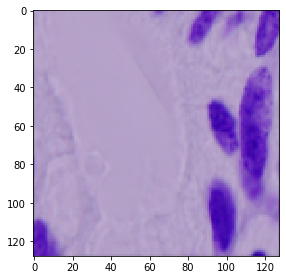

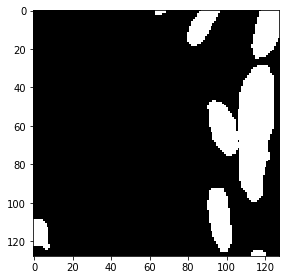

In [17]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

# Which Loss to use?
For Unet there are many differen but unkwons loss-fucntions to use. Often I see that people use cross entropy by default, however, that one is for segmentation far from perfect.

Cross-entropy is affected by the class proportions. Furthermore, cross-entropy is a surrogate accuracy function, adopted because it is nicely differentiable. However, this function does not really express the actual objective of our model to properly segment the different classes, whatever their areas. Therefore, several loss functions and metrics that are specific to semantic segmentation have been proposed by researchers to more explicitly capture this objective.

### Jaccard
The Jaccard Index, also known as the Jaccard similarity coefficient, is a statistic used in understanding the similarities between sample sets. The measurement emphasizes similarity between finite sample sets, and is formally defined as the size of the intersection divided by the size of the union of the sample sets. The mathematical representation of the index is written as:

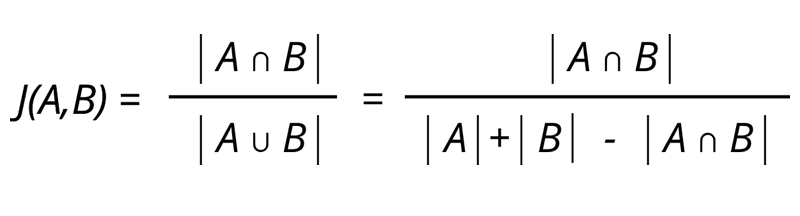

Similar to the Jaccard Index, which is a measurement of similarity, the Jaccard distance measures dissimilarity between sample sets. The Jaccard distance is calculated by finding the Jaccard index and subtracting it from 1, or alternatively dividing the differences ny the intersection of the two sets. 


In [333]:
def jaccard_distance(y_true, y_pred, smooth=100):
    """ Calculates mean of Jaccard distance as a loss function """

    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    sum_ = tf.reduce_sum(y_true_f + y_pred_f, axis=(1,2))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    jd =  (1 - jac) * smooth
    
    return tf.reduce_mean(jd)




### Dice Coefficient
The Dice coefficient is very similar to the Jaccard Index. The only solely biggest difference is that Jaccard considers the the triangle inequality. Since the Sørensen–Dice coefficient doesn't satisfy the triangle inequality, it can be considered a semimetric version of the Jaccard index.

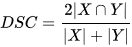

Which can be translated as: True Positive, False Negative, True Negative, False Positive:

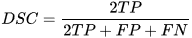


In [334]:

smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)




### Tversky Loss
Tversky index is a generalization of Dice’s coefficient. It only adds a weight to FP and FN.

In [1]:

def tversky_loss(beta):
  def loss(y_true, y_pred):
    numerator = tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = y_true * y_pred + beta * (1 - y_true) * y_pred + (1 - beta) * y_true * (1 - y_pred)

    return 1 - (numerator + 1) / (tf.reduce_sum(denominator, axis=-1) + 1)

  return loss



### Lovász-Softmax
Lovasz loss is differentiable surrogate of IOU. It's a smooth function that mimics IOU. 
However, this loss requires identity activation in the final layer. A negative value means in that case class A and a positive value means class B.

In [ ]:
def lovasz_softmax(y_true, y_pred):
 return lovasz_hinge(labels=y_true, logits=y_pred)

model.compile(loss=lovasz_softmax, optimizer=optimizer, metrics=[pixel_iou])

### Combination of Losses
It is not really popular and quite an experimental approach. But sometimes a combination of losses is used

In [ ]:
def loss(y_true, y_pred):
    def dice_loss(y_true, y_pred):
        numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
        denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))

        return tf.reshape(1 - numerator / denominator, (-1, 1, 1))

    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [8]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

loss      = dice_coef_loss
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=["accuracy", "mse"])
model.summary()

NameError: name 'IMG_HEIGHT' is not defined

In [339]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('Nuclei.h5', verbose=1, save_best_only=True)
history = model.fit (X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/50
592/603 [============================>.] - ETA: 1:29 - loss: 0.6266 - accuracy: 0.6549 - mse: 0.21 - ETA: 1:03 - loss: 0.6280 - accuracy: 0.6972 - mse: 0.20 - ETA: 54s - loss: 0.6020 - accuracy: 0.7296 - mse: 0.1996 - ETA: 48s - loss: 0.5785 - accuracy: 0.7409 - mse: 0.190 - ETA: 45s - loss: 0.5806 - accuracy: 0.7349 - mse: 0.191 - ETA: 42s - loss: 0.5683 - accuracy: 0.7404 - mse: 0.187 - ETA: 40s - loss: 0.5504 - accuracy: 0.7533 - mse: 0.180 - ETA: 38s - loss: 0.5319 - accuracy: 0.7609 - mse: 0.173 - ETA: 36s - loss: 0.5087 - accuracy: 0.7724 - mse: 0.165 - ETA: 35s - loss: 0.5142 - accuracy: 0.7724 - mse: 0.166 - ETA: 34s - loss: 0.5075 - accuracy: 0.7733 - mse: 0.164 - ETA: 33s - loss: 0.5024 - accuracy: 0.7776 - mse: 0.162 - ETA: 31s - loss: 0.4942 - accuracy: 0.7820 - mse: 0.159 - ETA: 30s - loss: 0.4910 - accuracy: 0.7825 - mse: 0.158 - ETA: 29s - loss: 0.4785 - accuracy: 0.7901 - mse: 0.153 - ETA: 28s - loss: 0.4677 - accu

592/603 [============================>.] - ETA: 51s - loss: 0.0867 - accuracy: 0.9682 - mse: 0.024 - ETA: 50s - loss: 0.0863 - accuracy: 0.9682 - mse: 0.024 - ETA: 48s - loss: 0.1008 - accuracy: 0.9623 - mse: 0.028 - ETA: 46s - loss: 0.1087 - accuracy: 0.9590 - mse: 0.030 - ETA: 45s - loss: 0.1064 - accuracy: 0.9599 - mse: 0.030 - ETA: 44s - loss: 0.1058 - accuracy: 0.9601 - mse: 0.030 - ETA: 43s - loss: 0.1014 - accuracy: 0.9621 - mse: 0.028 - ETA: 41s - loss: 0.1031 - accuracy: 0.9611 - mse: 0.029 - ETA: 40s - loss: 0.1015 - accuracy: 0.9616 - mse: 0.028 - ETA: 38s - loss: 0.1034 - accuracy: 0.9611 - mse: 0.029 - ETA: 37s - loss: 0.1033 - accuracy: 0.9612 - mse: 0.029 - ETA: 36s - loss: 0.1050 - accuracy: 0.9608 - mse: 0.029 - ETA: 34s - loss: 0.1042 - accuracy: 0.9610 - mse: 0.029 - ETA: 33s - loss: 0.1054 - accuracy: 0.9604 - mse: 0.029 - ETA: 32s - loss: 0.1048 - accuracy: 0.9604 - mse: 0.029 - ETA: 30s - loss: 0.1044 - accuracy: 0.9604 - mse: 0.029 - ETA: 29s - loss: 0.1092 - acc

592/603 [============================>.] - ETA: 50s - loss: 0.1119 - accuracy: 0.9577 - mse: 0.032 - ETA: 49s - loss: 0.0900 - accuracy: 0.9655 - mse: 0.025 - ETA: 48s - loss: 0.0908 - accuracy: 0.9648 - mse: 0.026 - ETA: 47s - loss: 0.0941 - accuracy: 0.9634 - mse: 0.027 - ETA: 45s - loss: 0.0914 - accuracy: 0.9646 - mse: 0.026 - ETA: 44s - loss: 0.0868 - accuracy: 0.9665 - mse: 0.024 - ETA: 43s - loss: 0.0903 - accuracy: 0.9648 - mse: 0.026 - ETA: 41s - loss: 0.0869 - accuracy: 0.9662 - mse: 0.025 - ETA: 40s - loss: 0.0845 - accuracy: 0.9670 - mse: 0.024 - ETA: 39s - loss: 0.0879 - accuracy: 0.9657 - mse: 0.025 - ETA: 37s - loss: 0.0848 - accuracy: 0.9669 - mse: 0.024 - ETA: 36s - loss: 0.0849 - accuracy: 0.9669 - mse: 0.024 - ETA: 34s - loss: 0.0855 - accuracy: 0.9666 - mse: 0.024 - ETA: 33s - loss: 0.0850 - accuracy: 0.9668 - mse: 0.024 - ETA: 32s - loss: 0.0849 - accuracy: 0.9668 - mse: 0.024 - ETA: 30s - loss: 0.0850 - accuracy: 0.9667 - mse: 0.024 - ETA: 29s - loss: 0.0860 - acc

592/603 [============================>.] - ETA: 52s - loss: 0.1007 - accuracy: 0.9614 - mse: 0.028 - ETA: 50s - loss: 0.0855 - accuracy: 0.9667 - mse: 0.024 - ETA: 48s - loss: 0.0837 - accuracy: 0.9674 - mse: 0.024 - ETA: 47s - loss: 0.0796 - accuracy: 0.9691 - mse: 0.022 - ETA: 46s - loss: 0.0822 - accuracy: 0.9678 - mse: 0.023 - ETA: 44s - loss: 0.0873 - accuracy: 0.9658 - mse: 0.025 - ETA: 43s - loss: 0.0813 - accuracy: 0.9682 - mse: 0.023 - ETA: 41s - loss: 0.0833 - accuracy: 0.9676 - mse: 0.024 - ETA: 40s - loss: 0.0843 - accuracy: 0.9669 - mse: 0.024 - ETA: 39s - loss: 0.0844 - accuracy: 0.9668 - mse: 0.024 - ETA: 37s - loss: 0.0823 - accuracy: 0.9677 - mse: 0.023 - ETA: 36s - loss: 0.0817 - accuracy: 0.9678 - mse: 0.023 - ETA: 34s - loss: 0.0828 - accuracy: 0.9675 - mse: 0.024 - ETA: 33s - loss: 0.0821 - accuracy: 0.9678 - mse: 0.023 - ETA: 32s - loss: 0.0832 - accuracy: 0.9675 - mse: 0.024 - ETA: 30s - loss: 0.0837 - accuracy: 0.9672 - mse: 0.024 - ETA: 29s - loss: 0.0843 - acc

In [21]:
# Predict on train, val and test
model = load_model('Nuclei.h5')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

603/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 31s 52ms/sample
67/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

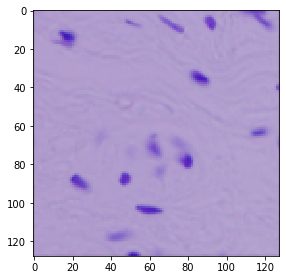

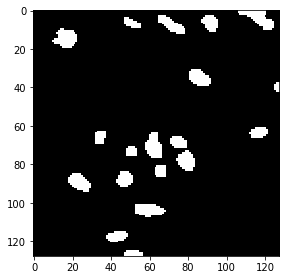

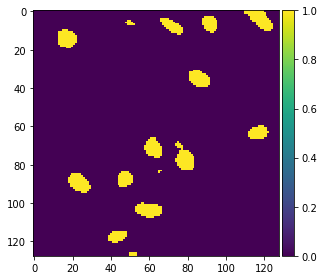

In [24]:

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

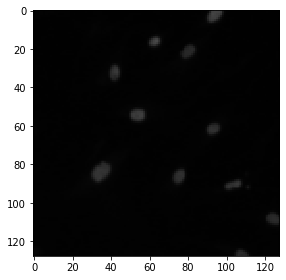

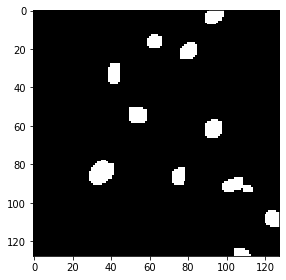

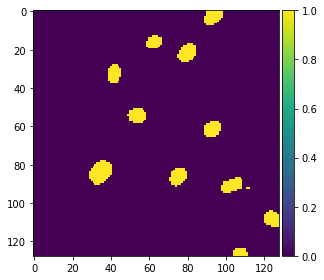

In [25]:
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

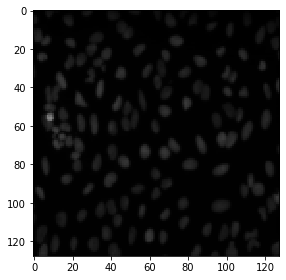

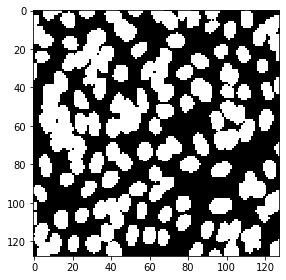

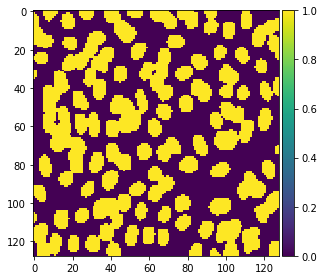

In [26]:
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()